In [1]:
%pip install plotly --upgrade # must use plotly 6.0.0 or above


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly # must be version 6.0.0 or above
print(plotly.__version__)
import plotly.graph_objects as go
import csv
import os.path

6.0.0


In [3]:
# create data directory path
data_dir = '/workspaces/sponsor-cosponsor-network/Data'

# create output directory path
out_dir = '/workspaces/sponsor-cosponsor-network/Output'

In [4]:
# read in data from csv
# works with csvs downloaded from https://www.congress.gov/browse/legislative-subject-terms
csvpath = os.path.join(data_dir, 'search_results_2025-01-28_0422pm.csv')

df = pd.read_csv(csvpath, header=2)
df.drop(columns=['URL', 'Congress', 'Date of Introduction'], inplace=True)
print(df.columns)

Index(['Legislation Number', 'Title', 'Sponsor', 'Party of Sponsor',
       'Cosponsor', 'Cosponsor.1', 'Cosponsor.2', 'Cosponsor.3', 'Cosponsor.4',
       'Cosponsor.5', 'Cosponsor.6', 'Cosponsor.7', 'Cosponsor.8',
       'Cosponsor.9', 'Cosponsor.10', 'Cosponsor.11', 'Cosponsor.12',
       'Cosponsor.13', 'Cosponsor.14', 'Cosponsor.15', 'Cosponsor.16',
       'Cosponsor.17', 'Cosponsor.18', 'Cosponsor.19', 'Cosponsor.20',
       'Cosponsor.21', 'Cosponsor.22', 'Cosponsor.23', 'Cosponsor.24',
       'Cosponsor.25', 'Cosponsor.26', 'Cosponsor.27', 'Cosponsor.28',
       'Cosponsor.29', 'Cosponsor.30', 'Cosponsor.31', 'Cosponsor.32',
       'Cosponsor.33', 'Cosponsor.34', 'Cosponsor.35', 'Cosponsor.36',
       'Latest Summary'],
      dtype='object')


In [5]:
# functions
def remove_parens(text):
  """
  Remove parenthetical from text.

  Args:
    text: A string containing parentheses.

  Returns:
    A string with parentheses removed.
  """
  return re.sub(r'\([^)]*\)', '', text)

def group_bills_by_node(df, colname='sponsored'):
  """
  Groups bill numbers by sponsor or cosponsor node ID.

  Args:
    df: A pandas DataFrame with columns 'node_id' and colname (default colname is 'sponsored').

  Returns:
    A dataframe where unique node IDs are associated with a list of bill numbers.
  """
  unique_nodes = df['node_id'].unique()
  node_bills = {}
  for node in unique_nodes:
    node_bills[node] = df[df['node_id'] == node][colname].tolist()
    node_bills[node] = ', '.join(sorted(list(set(node_bills[node]))))

  return pd.DataFrame(list(node_bills.items()), columns=['node_id', 'bill_numbers'])

In [6]:
# Melt the multiple cosponsor columns into one
df_melted = df.melt(id_vars=['Legislation Number',
                             'Title',
                             'Sponsor'],
                    value_vars=[col for col in df.columns if col.startswith("Cosponsor")])
df_melted.columns = ['Legislation Number',
                     'title',
                     'sponsor',
                     'variable',
                     'cosponsor']

# drop rows that don't include a bill number
df_melted = df_melted.dropna(subset=['Legislation Number'])

# remove parentheticals from Sponsor column
df_melted['sponsor'] = df_melted['sponsor'].apply(remove_parens)

# split Sponsor and Cosponsor columns into Name and Title_Party_State
df_melted[['sponsor_name',
           'sponsor_title_party_state']] = df_melted['sponsor'].str.extract(r'(.+?)\s*(\[[^\]]+\])')
df_melted[['cosponsor_name',
           'cosponsor_title_party_state']] = df_melted['cosponsor'].str.extract(r'(.+?)\s*(\[[^\]]+\])')
df_melted[['sp_last_name',
           'sp_first_name']] = df_melted['sponsor_name'].str.split(',', expand=True, n=1)
df_melted[['cos_last_name',
           'cos_first_name']] = df_melted['cosponsor_name'].str.split(',', expand=True, n=1)
df_melted['sponsor_name'] = df_melted['sp_first_name'] + ' ' + df_melted['sp_last_name']
df_melted['sponsor_name'] = df_melted['sponsor_name'].str.strip()
df_melted['cosponsor_name'] = df_melted['cos_first_name'] + ' ' + df_melted['cos_last_name']
df_melted['cosponsor_name'] = df_melted['cosponsor_name'].str.strip()

# remove brackets from Title_Party_State
df_melted['sponsor_title_party_state'] = df_melted['sponsor_title_party_state'].astype(str).str.strip("[]").str.replace("'", "")
df_melted['cosponsor_title_party_state'] = df_melted['cosponsor_title_party_state'].astype(str).str.strip("[]").str.replace("'", "")

# split Title_Party_State
df_melted[['sp_title',
           'sp_party',
           'sp_state',
           'sp_district']] = df_melted['sponsor_title_party_state'].str.split('-', expand=True)
df_melted[['cos_title',
           'cos_party',
           'cos_state',
           'cos_district']] = df_melted['cosponsor_title_party_state'].str.split('-', expand=True)
df_melted = df_melted.drop(columns=['sponsor_title_party_state',
                                    'cosponsor_title_party_state',
                                    'sp_district',
                                    'cos_district'])
df_melted['sponsor_name'] = df_melted['sp_title'] + ' ' + df_melted['sponsor_name'] + ', ' + df_melted['sp_party'] + '-' + df_melted['sp_state']
df_melted['cosponsor_name'] = df_melted['cos_title'] + ' ' + df_melted['cosponsor_name'] + ', ' + df_melted['cos_party'] + '-' + df_melted['cos_state']

# drop extra columns
df_melted = df_melted.drop(columns=['sponsor',
                                    'variable',
                                    'cosponsor',
                                    'sp_first_name',
                                    'sp_last_name',
                                    'cos_first_name',
                                    'cos_last_name',
                                    'sp_title',
                                    'cos_title',
                                    'sp_state',
                                    'cos_state'])

print(df_melted.head())

  Legislation Number                                              title  \
0          H.R. 7024  Tax Relief for American Families and Workers A...   
1          H.R. 5988  United States-Taiwan Expedited Double-Tax Reli...   
2          H.R. 3938                            Build It in America Act   
3          H.R. 1046                      Social Security Expansion Act   
4          H.R. 1040                                       Flat Tax Act   

                      sponsor_name             cosponsor_name sp_party  \
0           Rep. Jason Smith, R-MO                        NaN        R   
1           Rep. Jason Smith, R-MO  Rep. Michelle Steel, R-CA        R   
2           Rep. Jason Smith, R-MO                        NaN        R   
3  Rep. Janice D. Schakowsky, D-IL  Rep. Jill N. Tokuda, D-HI        D   
4    Rep. Michael C. Burgess, R-TX                        NaN        R   

  cos_party  
0      None  
1         R  
2      None  
3         D  
4      None  


In [7]:
# make a dataframe of unique bills & their sponsors
grouped = df_melted.groupby('Legislation Number')
bill_df = grouped.first().reset_index()[['Legislation Number',
                                         'sponsor_name',
                                         'sp_party']]
print(bill_df)

   Legislation Number                       sponsor_name sp_party
0         H.J.Res. 12            Rep. Zachary Nunn, R-IA        R
1         H.J.Res. 19             Rep. Scott Perry, R-PA        R
2          H.J.Res. 2           Rep. Vern Buchanan, R-FL        R
3         H.J.Res. 21       Rep. Derrick Van Orden, R-WI        R
4         H.J.Res. 55              Rep. Rudy Yakym, R-IN        R
5         H.J.Res. 56           Rep. Mark E. Green, R-TN        R
6         H.J.Res. 67          Rep. August Pfluger, R-TX        R
7           H.R. 1040      Rep. Michael C. Burgess, R-TX        R
8           H.R. 1046    Rep. Janice D. Schakowsky, D-IL        D
9             H.R. 25  Rep. Earl L. "Buddy" Carter, R-GA        R
10          H.R. 3938             Rep. Jason Smith, R-MO        R
11           H.R. 579       Rep. W. Gregory Steube, R-FL        R
12          H.R. 5988             Rep. Jason Smith, R-MO        R
13          H.R. 7024             Rep. Jason Smith, R-MO        R
14        

In [8]:
# make a dataframe of bill nodes
bill_df.columns = ['label', 'sponsor', 'party']
bill_df['node_type'] = 'bill'
bill_df['size'] = 128
## bill color will be based on sponsor's party
bill_df['color'] = bill_df['party'].apply(lambda x: '#B22222' if x == 'R' else '#0047AB' if x == 'D' else '#FFAA33')
bill_df.drop(columns=['party'], inplace=True)
bill_df['shape'] = 's' # all bill nodes will be square
bill_df['sponsored'] = 'NA'
bill_df['cosponsored'] = 'NA'
bill_df['node_id'] = bill_df.index + 1

# create a NetworkX graph
G = nx.Graph()

# add bill nodes to graph
for _, row in bill_df.iterrows():
   G.add_node(row['node_id'], **row.drop('node_id').to_dict())

# print nodes with attributes
for node, attributes in G.nodes(data=True):
    print(f"Node: {node}, Attributes: {attributes}")

Node: 1, Attributes: {'label': 'H.J.Res. 12', 'sponsor': 'Rep. Zachary Nunn, R-IA', 'node_type': 'bill', 'size': 128, 'color': '#B22222', 'shape': 's', 'sponsored': 'NA', 'cosponsored': 'NA'}
Node: 2, Attributes: {'label': 'H.J.Res. 19', 'sponsor': 'Rep. Scott Perry, R-PA', 'node_type': 'bill', 'size': 128, 'color': '#B22222', 'shape': 's', 'sponsored': 'NA', 'cosponsored': 'NA'}
Node: 3, Attributes: {'label': 'H.J.Res. 2', 'sponsor': 'Rep. Vern Buchanan, R-FL', 'node_type': 'bill', 'size': 128, 'color': '#B22222', 'shape': 's', 'sponsored': 'NA', 'cosponsored': 'NA'}
Node: 4, Attributes: {'label': 'H.J.Res. 21', 'sponsor': 'Rep. Derrick Van Orden, R-WI', 'node_type': 'bill', 'size': 128, 'color': '#B22222', 'shape': 's', 'sponsored': 'NA', 'cosponsored': 'NA'}
Node: 5, Attributes: {'label': 'H.J.Res. 55', 'sponsor': 'Rep. Rudy Yakym, R-IN', 'node_type': 'bill', 'size': 128, 'color': '#B22222', 'shape': 's', 'sponsored': 'NA', 'cosponsored': 'NA'}
Node: 6, Attributes: {'label': 'H.J.Re

In [9]:
# examine bill_df
bill_df

,label,sponsor,node_type,size,color,shape,sponsored,cosponsored,node_id
0,H.J.Res. 12,"Rep. Zachary Nunn, R-IA",bill,128,#B22222,s,NA,NA,1
1,H.J.Res. 19,"Rep. Scott Perry, R-PA",bill,128,#B22222,s,NA,NA,2
2,H.J.Res. 2,"Rep. Vern Buchanan, R-FL",bill,128,#B22222,s,NA,NA,3
3,H.J.Res. 21,"Rep. Derrick Van Orden, R-WI",bill,128,#B22222,s,NA,NA,4
4,H.J.Res. 55,"Rep. Rudy Yakym, R-IN",bill,128,#B22222,s,NA,NA,5
5,H.J.Res. 56,"Rep. Mark E. Green, R-TN",bill,128,#B22222,s,NA,NA,6
6,H.J.Res. 67,"Rep. August Pfluger, R-TX",bill,128,#B22222,s,NA,NA,7
7,H.R. 1040,"Rep. Michael C. Burgess, R-TX",bill,128,#B22222,s,NA,NA,8
8,H.R. 1046,"Rep. Janice D. Schakowsky, D-IL",bill,128,#0047AB,s,NA,NA,9
9,H.R. 25,"Rep. Earl L. ""Buddy"" Carter, R-GA",bill,128,#B22222,s,NA,NA,10


In [10]:
# create a dataframe of unique sponsors with node_ids; some legislators may sponsor more than one bill.
sponsor_df = df_melted[['sponsor_name', 'sp_party']].sort_values(by='sponsor_name').drop_duplicates().reset_index(drop=True)
sponsor_df.columns = ['label', 'party']
sponsor_df['sponsor'] = 'NA'
sponsor_df['node_type'] = 'sponsor'
sponsor_df['cosponsored'] = 'NA'
sponsor_df['size'] = 128
sponsor_df['color'] = sponsor_df['party'].apply(lambda x: '#B22222' if x == 'R' else '#0047AB' if x == 'D' else '#FFAA33')
sponsor_df.drop(columns=['party'], inplace=True)
sponsor_df['shape'] = '^' # sponsor-only nodes will be triangles
sponsor_df['node_id'] = sponsor_df.index + len(G.nodes) + 1

# examine sponsor_df
sponsor_df

,label,sponsor,node_type,cosponsored,size,color,shape,node_id
0,"Rep. August Pfluger, R-TX",NA,sponsor,NA,128,#B22222,^,24
1,"Rep. Derrick Van Orden, R-WI",NA,sponsor,NA,128,#B22222,^,25
2,"Rep. Earl L. ""Buddy"" Carter, R-GA",NA,sponsor,NA,128,#B22222,^,26
3,"Rep. Janice D. Schakowsky, D-IL",NA,sponsor,NA,128,#0047AB,^,27
4,"Rep. Jason Smith, R-MO",NA,sponsor,NA,128,#B22222,^,28
5,"Rep. Mark E. Green, R-TN",NA,sponsor,NA,128,#B22222,^,29
6,"Rep. Michael C. Burgess, R-TX",NA,sponsor,NA,128,#B22222,^,30
7,"Rep. Rudy Yakym, R-IN",NA,sponsor,NA,128,#B22222,^,31
8,"Rep. Scott Perry, R-PA",NA,sponsor,NA,128,#B22222,^,32
9,"Rep. Steve Scalise, R-LA",NA,sponsor,NA,128,#B22222,^,33


In [11]:
# add sponsor nodes to graph
for _, row in sponsor_df.iterrows():
    G.add_node(row['node_id'], **row.drop('node_id').to_dict())

# filter nodes with the attribute 'node_type' as 'sponsor'
sponsor_nodes = {node: data for node, data in G.nodes(data=True) if data.get("node_type") == "sponsor"}

# print sponsor nodes with attributes
for node, attributes in sponsor_nodes.items():
    print(f"Node: {node}, Attributes: {attributes}")

Node: 24, Attributes: {'label': 'Rep. August Pfluger, R-TX', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, 'color': '#B22222', 'shape': '^'}
Node: 25, Attributes: {'label': 'Rep. Derrick Van Orden, R-WI', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, 'color': '#B22222', 'shape': '^'}
Node: 26, Attributes: {'label': 'Rep. Earl L. "Buddy" Carter, R-GA', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, 'color': '#B22222', 'shape': '^'}
Node: 27, Attributes: {'label': 'Rep. Janice D. Schakowsky, D-IL', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, 'color': '#0047AB', 'shape': '^'}
Node: 28, Attributes: {'label': 'Rep. Jason Smith, R-MO', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, 'color': '#B22222', 'shape': '^'}
Node: 29, Attributes: {'label': 'Rep. Mark E. Green, R-TN', 'sponsor': 'NA', 'node_type': 'sponsor', 'cosponsored': 'NA', 'size': 128, '

In [12]:
# join sponsor_df to bill_df on sponsor name to get 'sponsored' bill(s)
sponsor_df = sponsor_df.merge(bill_df, left_on='label', right_on='sponsor', how='left')

# drop most bill columns
sponsor_df = sponsor_df[['label_x',
                         'sponsor_x',
                         'node_type_x',
                         'cosponsored_x',
                         'size_x',
                         'color_x',
                         'shape_x',
                         'node_id_x',
                         'label_y']]

# rename remaining columns
sponsor_df.columns = ['label',
                      'sponsor',
                      'node_type',
                      'cosponsored',
                      'size',
                      'color',
                      'shape',
                      'node_id',
                      'sponsored']

## drop party and reorder remaining sponsor_df columns
sponsor_df = sponsor_df[['label',
                         'sponsor',
                         'node_type',
                         'size',
                         'color',
                         'shape',
                         'sponsored',
                         'cosponsored',
                         'node_id']]

# examine revised sponsor_df
sponsor_df

,label,sponsor,node_type,size,color,shape,sponsored,cosponsored,node_id
0,"Rep. August Pfluger, R-TX",NA,sponsor,128,#B22222,^,H.J.Res. 67,NA,24
1,"Rep. Derrick Van Orden, R-WI",NA,sponsor,128,#B22222,^,H.J.Res. 21,NA,25
2,"Rep. Earl L. ""Buddy"" Carter, R-GA",NA,sponsor,128,#B22222,^,H.R. 25,NA,26
3,"Rep. Janice D. Schakowsky, D-IL",NA,sponsor,128,#0047AB,^,H.R. 1046,NA,27
4,"Rep. Jason Smith, R-MO",NA,sponsor,128,#B22222,^,H.R. 3938,NA,28
5,"Rep. Jason Smith, R-MO",NA,sponsor,128,#B22222,^,H.R. 5988,NA,28
6,"Rep. Jason Smith, R-MO",NA,sponsor,128,#B22222,^,H.R. 7024,NA,28
7,"Rep. Mark E. Green, R-TN",NA,sponsor,128,#B22222,^,H.J.Res. 56,NA,29
8,"Rep. Michael C. Burgess, R-TX",NA,sponsor,128,#B22222,^,H.R. 1040,NA,30
9,"Rep. Rudy Yakym, R-IN",NA,sponsor,128,#B22222,^,H.J.Res. 55,NA,31


In [13]:
# limit df to just label, sponsored
sponsored_bill_df = sponsor_df[['node_id', 'label', 'sponsored']].sort_values(by='node_id')

# create dataframe of sponsor nodes with lists of their sponsored bills
node_bills = group_bills_by_node(sponsored_bill_df, 'sponsored')
print(node_bills)

# iterate through node_bills changing 'sponsored' attribute of sponsor nodes
for _, row in node_bills.iterrows():
  G.nodes[row['node_id']]['sponsored'] = row['bill_numbers']

# verify modification
for node, attributes in sponsor_nodes.items():
    print(f"Node: {node}, Attributes: {attributes}")

    node_id                     bill_numbers
0        24                      H.J.Res. 67
1        25                      H.J.Res. 21
2        26                          H.R. 25
3        27                        H.R. 1046
4        28  H.R. 3938, H.R. 5988, H.R. 7024
5        29                      H.J.Res. 56
6        30                        H.R. 1040
7        31                      H.J.Res. 55
8        32                      H.J.Res. 19
9        33                         H.Res. 5
10       34                       H.J.Res. 2
11       35                         H.R. 579
12       36                      H.J.Res. 12
13       37                           S. 393
14       38                      S.J.Res. 13
15       39                          S. 2281
16       40                           S. 153
17       41                      S.J.Res. 14
18       42                       S.J.Res. 1
19       43                          S. 3084
20       44                             S. 6
Node: 24, 

In [14]:
# create edge list for bills and sponsors
## merge bill_nodes_df with sponsors_df
bill_sponsor_edges = bill_df.merge(sponsor_df[['label', 'node_id']],
                                   left_on='sponsor',
                                   right_on='label',
                                   how='left')
bill_sponsor_edges.drop(columns=['size', 'shape'], axis=1, inplace=True)
bill_sponsor_edges['color'] = 'cyan' # sponsorship edges will be cyan
bill_sponsor_edges.rename(columns={'node_id_x': 'target',
                                   'node_id_y': 'source'}, inplace=True)
bill_sponsor_edges = bill_sponsor_edges[['source', 'target', 'color']]

## add sponsor edges to graph
for _, row in bill_sponsor_edges.iterrows():
  G.add_edge(row['source'], row['target'], color=row['color'])

## print edge list
for target, source, attributes in G.edges(data=True):
    print(f"Edge: {(target, source)}, Attributes: {attributes}")

Edge: (1, 36), Attributes: {'color': 'cyan'}
Edge: (2, 32), Attributes: {'color': 'cyan'}
Edge: (3, 34), Attributes: {'color': 'cyan'}
Edge: (4, 25), Attributes: {'color': 'cyan'}
Edge: (5, 31), Attributes: {'color': 'cyan'}
Edge: (6, 29), Attributes: {'color': 'cyan'}
Edge: (7, 24), Attributes: {'color': 'cyan'}
Edge: (8, 30), Attributes: {'color': 'cyan'}
Edge: (9, 27), Attributes: {'color': 'cyan'}
Edge: (10, 26), Attributes: {'color': 'cyan'}
Edge: (11, 28), Attributes: {'color': 'cyan'}
Edge: (12, 35), Attributes: {'color': 'cyan'}
Edge: (13, 28), Attributes: {'color': 'cyan'}
Edge: (14, 28), Attributes: {'color': 'cyan'}
Edge: (15, 33), Attributes: {'color': 'cyan'}
Edge: (16, 40), Attributes: {'color': 'cyan'}
Edge: (17, 39), Attributes: {'color': 'cyan'}
Edge: (18, 43), Attributes: {'color': 'cyan'}
Edge: (19, 37), Attributes: {'color': 'cyan'}
Edge: (20, 44), Attributes: {'color': 'cyan'}
Edge: (21, 42), Attributes: {'color': 'cyan'}
Edge: (22, 38), Attributes: {'color': 'cyan

In [15]:
# make a dataframe of cosponsors
## group by cosponsor_name
grouped = df_melted.groupby('cosponsor_name')
cosponsor_df = grouped.first().reset_index()[['cosponsor_name',
                                              'cos_party',
                                              'Legislation Number']]
print('No. of Unique Cosponsors: ' + str(len(cosponsor_df['cosponsor_name'].unique())))
del grouped, df_melted

## limit dataframe to unique cosponsors
cosponsor_nodes_df = cosponsor_df['cosponsor_name'].drop_duplicates().reset_index(drop=True)
cosponsor_nodes_df = pd.DataFrame(cosponsor_nodes_df)
cosponsor_nodes_df.columns = ['label']

## merge cosponsor_nodes_df with cosponsor_df to add party
cosponsor_nodes_df = cosponsor_nodes_df.merge(cosponsor_df,
                                              left_on='label',
                                              right_on='cosponsor_name').drop(['cosponsor_name'], axis=1)
cosponsor_nodes_df['size'] = 60
cosponsor_nodes_df['color'] = cosponsor_nodes_df['cos_party'].apply(lambda x: '#B22222' if x == 'R' else '#0047AB' if x == 'D' else '#FFAA33')
cosponsor_nodes_df['shape'] = 'o' # cosponsor nodes will be circles
cosponsor_nodes_df.rename(columns={'cos_party': 'party', 'Legislation Number': 'bill'}, inplace=True)
cosponsor_nodes_df.drop(columns=['party'], inplace=True)
cosponsor_nodes_df['node_id'] = cosponsor_nodes_df.index + len(G.nodes) + 1

# examine cosponsors
cosponsor_nodes_df

No. of Unique Cosponsors: 150


,label,bill,size,color,shape,node_id
0,"Del. Eleanor Holmes Norton, D-DC",H.R. 1046,60,#0047AB,o,45
1,"Del. Gregorio Kilili Camacho Sablan, D-MP",H.R. 1046,60,#0047AB,o,46
2,"Del. Stacey E. Plaskett, D-VI",H.R. 5988,60,#0047AB,o,47
3,"Rep. Adrian Smith, R-NE",H.R. 5988,60,#B22222,o,48
4,"Rep. Al Green, D-TX",H.R. 1046,60,#0047AB,o,49
...,...,...,...,...,...,...
145,"Sen. Steve Daines, R-MT",S.J.Res. 13,60,#B22222,o,190
146,"Sen. Ted Budd, R-NC",S.J.Res. 13,60,#B22222,o,191
147,"Sen. Thomas Tillis, R-NC",S.J.Res. 13,60,#B22222,o,192
148,"Sen. Tina Smith, D-MN",S. 393,60,#0047AB,o,193


In [16]:
# check for overlap between cosponsors and sponsors
overlap_nodes_df = cosponsor_nodes_df.merge(sponsor_df,
                                            left_on='label',
                                            right_on='label',
                                            how='inner',
                                            suffixes=('_cosponsor', '_sponsor'))
overlap_nodes_df = overlap_nodes_df[['label', 'bill', 'node_id_sponsor']]
overlap_nodes_df.columns = ['label', 'cosponsored', 'node_id']
print(overlap_nodes_df) # these nodes have already been added to the graph as sponsors

# make list of non-overlapping cosponsors
csonly_nodes_df = cosponsor_nodes_df[~cosponsor_nodes_df['label'].isin(overlap_nodes_df['label'])].reset_index()

# add node_id to csonly_nodes_df
csonly_nodes_df['node_id'] = csonly_nodes_df.index + len(G.nodes) + 1
csonly_nodes_df.rename({'bill': 'cosponsored'}, axis=1, inplace=True)
csonly_nodes_df['sponsor'] = 'NA'
csonly_nodes_df['sponsored'] = 'NA'
# reorder columns
csonly_nodes_df = csonly_nodes_df[['label',
                                   'sponsor',
                                   'size',
                                   'color',
                                   'shape',
                                   'sponsored',
                                   'cosponsored',
                                   'node_id']]
print(csonly_nodes_df)

                          label  cosponsored  node_id
0        Rep. Scott Perry, R-PA      H.R. 25       32
1  Sen. Cynthia M. Lummis, R-WY  S.J.Res. 13       39
2           Sen. Mike Lee, R-UT  S.J.Res. 13       41
3       Sen. Steve Daines, R-MT  S.J.Res. 13       44
                                         label sponsor  size    color shape  \
0             Del. Eleanor Holmes Norton, D-DC      NA    60  #0047AB     o   
1    Del. Gregorio Kilili Camacho Sablan, D-MP      NA    60  #0047AB     o   
2                Del. Stacey E. Plaskett, D-VI      NA    60  #0047AB     o   
3                      Rep. Adrian Smith, R-NE      NA    60  #B22222     o   
4                          Rep. Al Green, D-TX      NA    60  #0047AB     o   
..                                         ...     ...   ...      ...   ...   
141            Sen. Shelley Moore Capito, R-WV      NA    60  #B22222     o   
142                        Sen. Ted Budd, R-NC      NA    60  #B22222     o   
143                

In [17]:
# merge csonly_nodes_df with bill_nodes_df to add bill_node_id
csonly_nodes_df = csonly_nodes_df.merge(bill_df[['label', 'node_id']],
                                        left_on='cosponsored',
                                        right_on='label',
                                        how='left')
csonly_nodes_df.drop(columns=['label_y'], inplace=True)
csonly_nodes_df.columns = ['label',
                           'sponsor',
                           'size',
                           'color',
                           'shape',
                           'sponsored',
                           'cosponsored',
                           'target',
                           'source']

# reorder columns
csonly_nodes_df = csonly_nodes_df[['label',
                                   'sponsor',
                                   'size',
                                   'color',
                                   'shape',
                                   'sponsored',
                                   'cosponsored',
                                   'source',
                                   'target']]
csonly_nodes_df

,label,sponsor,size,color,shape,sponsored,cosponsored,source,target
0,"Del. Eleanor Holmes Norton, D-DC",NA,60,#0047AB,o,NA,H.R. 1046,9,45
1,"Del. Gregorio Kilili Camacho Sablan, D-MP",NA,60,#0047AB,o,NA,H.R. 1046,9,46
2,"Del. Stacey E. Plaskett, D-VI",NA,60,#0047AB,o,NA,H.R. 5988,13,47
3,"Rep. Adrian Smith, R-NE",NA,60,#B22222,o,NA,H.R. 5988,13,48
4,"Rep. Al Green, D-TX",NA,60,#0047AB,o,NA,H.R. 1046,9,49
...,...,...,...,...,...,...,...,...,...
141,"Sen. Shelley Moore Capito, R-WV",NA,60,#B22222,o,NA,S.J.Res. 13,22,186
142,"Sen. Ted Budd, R-NC",NA,60,#B22222,o,NA,S.J.Res. 13,22,187
143,"Sen. Thomas Tillis, R-NC",NA,60,#B22222,o,NA,S.J.Res. 13,22,188
144,"Sen. Tina Smith, D-MN",NA,60,#0047AB,o,NA,S. 393,19,189


In [18]:
# make bill-consponsor-only edge list
bill_cosponsor_edges = csonly_nodes_df[['source', 'target']].reset_index()
bill_cosponsor_edges['color'] = 'pink' # cosponsor edges will be pink
print(bill_cosponsor_edges)

# add cosponsor-only nodes to graph
csonly_nodes_df = csonly_nodes_df.rename(columns={'target': 'node_id'})
csonly_nodes_df['node_type'] = 'cosponsor'
print(csonly_nodes_df)

for _, row in csonly_nodes_df.iterrows():
    G.add_node(row['node_id'], **row.drop('node_id').to_dict())

# create dataframe of cosponsor-only nodes with lists of their cosponsored bills
node_bills = group_bills_by_node(csonly_nodes_df, 'cosponsored')
print(node_bills)

# iterate through node_bills changing 'cosponsored' attribute of cosponsor-only nodes
for _, row in node_bills.iterrows():
  G.nodes[row['node_id']]['cosponsored'] = row['bill_numbers']

# filter nodes for node_type 'cosponsor'
csonly_nodes = {node: data for node, data in G.nodes(data=True) if data.get("node_type") == "cosponsor"}

# verify modification
for node, attributes in csonly_nodes.items():
    print(f"Node: {node}, Attributes: {attributes}")

# print cosponsor only nodes
for node, attributes in csonly_nodes.items():
    print(f"Node: {node}, Attributes: {attributes}")

# add bill-cosponsor edges to graph
for _, row in bill_cosponsor_edges.iterrows():
  G.add_edge(row['source'], row['target'], color=row['color'])

# print edge list
for target, source, attributes in G.edges(data=True):
    print(f"Edge: {(target, source)}, Attributes: {attributes}")


     index  source  target color
0        0       9      45  pink
1        1       9      46  pink
2        2      13      47  pink
3        3      13      48  pink
4        4       9      49  pink
..     ...     ...     ...   ...
141    141      22     186  pink
142    142      22     187  pink
143    143      22     188  pink
144    144      19     189  pink
145    145      22     190  pink

[146 rows x 4 columns]
                                         label sponsor  size    color shape  \
0             Del. Eleanor Holmes Norton, D-DC      NA    60  #0047AB     o   
1    Del. Gregorio Kilili Camacho Sablan, D-MP      NA    60  #0047AB     o   
2                Del. Stacey E. Plaskett, D-VI      NA    60  #0047AB     o   
3                      Rep. Adrian Smith, R-NE      NA    60  #B22222     o   
4                          Rep. Al Green, D-TX      NA    60  #0047AB     o   
..                                         ...     ...   ...      ...   ...   
141            Sen. Shelley

In [19]:
# create dataframe of overlap nodes with lists of their cosponsored bills
node_bills = group_bills_by_node(overlap_nodes_df, 'cosponsored')
print(node_bills)

# iterate through node_bills changing 'cosponsored' attribute of sponsor nodes
# shape, and node_type values
for _, row in node_bills.iterrows():
  G.nodes[row['node_id']]['cosponsored'] = row['bill_numbers']
  G.nodes[row['node_id']]['shape'] = 'H'
  G.nodes[row['node_id']]['node_type'] = 'sponsor/cosponsor'

# filter nodes for node_type 'sponsor/cosponsor'
spcs_nodes = {node: data for node, data in G.nodes(data=True) if data.get("node_type") == "sponsor/cosponsor"}

# verify modification
for node, attributes in spcs_nodes.items():
    print(f"Node: {node}, Attributes: {attributes}")

   node_id bill_numbers
0       32      H.R. 25
1       39  S.J.Res. 13
2       41  S.J.Res. 13
3       44  S.J.Res. 13
Node: 32, Attributes: {'label': 'Rep. Scott Perry, R-PA', 'sponsor': 'NA', 'node_type': 'sponsor/cosponsor', 'cosponsored': 'H.R. 25', 'size': 128, 'color': '#B22222', 'shape': 'H', 'sponsored': 'H.J.Res. 19'}
Node: 39, Attributes: {'label': 'Sen. Cynthia M. Lummis, R-WY', 'sponsor': 'NA', 'node_type': 'sponsor/cosponsor', 'cosponsored': 'S.J.Res. 13', 'size': 128, 'color': '#B22222', 'shape': 'H', 'sponsored': 'S. 2281'}
Node: 41, Attributes: {'label': 'Sen. Mike Lee, R-UT', 'sponsor': 'NA', 'node_type': 'sponsor/cosponsor', 'cosponsored': 'S.J.Res. 13', 'size': 128, 'color': '#B22222', 'shape': 'H', 'sponsored': 'S.J.Res. 14'}
Node: 44, Attributes: {'label': 'Sen. Steve Daines, R-MT', 'sponsor': 'NA', 'node_type': 'sponsor/cosponsor', 'cosponsored': 'S.J.Res. 13', 'size': 128, 'color': '#B22222', 'shape': 'H', 'sponsored': 'S. 6'}


In [20]:
# create edge dataframe for overlap nodes
overlap_nodes_df = overlap_nodes_df.merge(bill_df,
                                          left_on='cosponsored',
                                          right_on='label',
                                          how='left')
overlap_nodes_df = overlap_nodes_df[['node_id_x', 'node_id_y']]
overlap_nodes_df = overlap_nodes_df[['node_id_x', 'node_id_y']].rename(columns={'node_id_x': 'target',
                                                                                'node_id_y': 'source'})
overlap_nodes_df['color'] = 'pink' # these edges represent cosponsorship
overlap_nodes_df

,target,source,color
0,32,10,pink
1,39,22,pink
2,41,22,pink
3,44,22,pink


In [21]:
# add cosponsorship edges for legislators who are both sponsors and cosponsors
for _, row in overlap_nodes_df.iterrows():
  G.add_edge(row['source'], row['target'], color=row['color'])

## print edge list
for target, source, attributes in G.edges(data=True):
    print(f"Edge: {(target, source)}, Attribute: {attributes}")

Edge: (1, 36), Attribute: {'color': 'cyan'}
Edge: (1, 64), Attribute: {'color': 'pink'}
Edge: (1, 71), Attribute: {'color': 'pink'}
Edge: (1, 79), Attribute: {'color': 'pink'}
Edge: (1, 82), Attribute: {'color': 'pink'}
Edge: (1, 85), Attribute: {'color': 'pink'}
Edge: (1, 91), Attribute: {'color': 'pink'}
Edge: (1, 94), Attribute: {'color': 'pink'}
Edge: (1, 96), Attribute: {'color': 'pink'}
Edge: (1, 111), Attribute: {'color': 'pink'}
Edge: (1, 122), Attribute: {'color': 'pink'}
Edge: (1, 123), Attribute: {'color': 'pink'}
Edge: (1, 131), Attribute: {'color': 'pink'}
Edge: (1, 134), Attribute: {'color': 'pink'}
Edge: (1, 139), Attribute: {'color': 'pink'}
Edge: (1, 141), Attribute: {'color': 'pink'}
Edge: (1, 142), Attribute: {'color': 'pink'}
Edge: (1, 143), Attribute: {'color': 'pink'}
Edge: (1, 151), Attribute: {'color': 'pink'}
Edge: (1, 152), Attribute: {'color': 'pink'}
Edge: (1, 154), Attribute: {'color': 'pink'}
Edge: (2, 32), Attribute: {'color': 'cyan'}
Edge: (2, 52), Attri

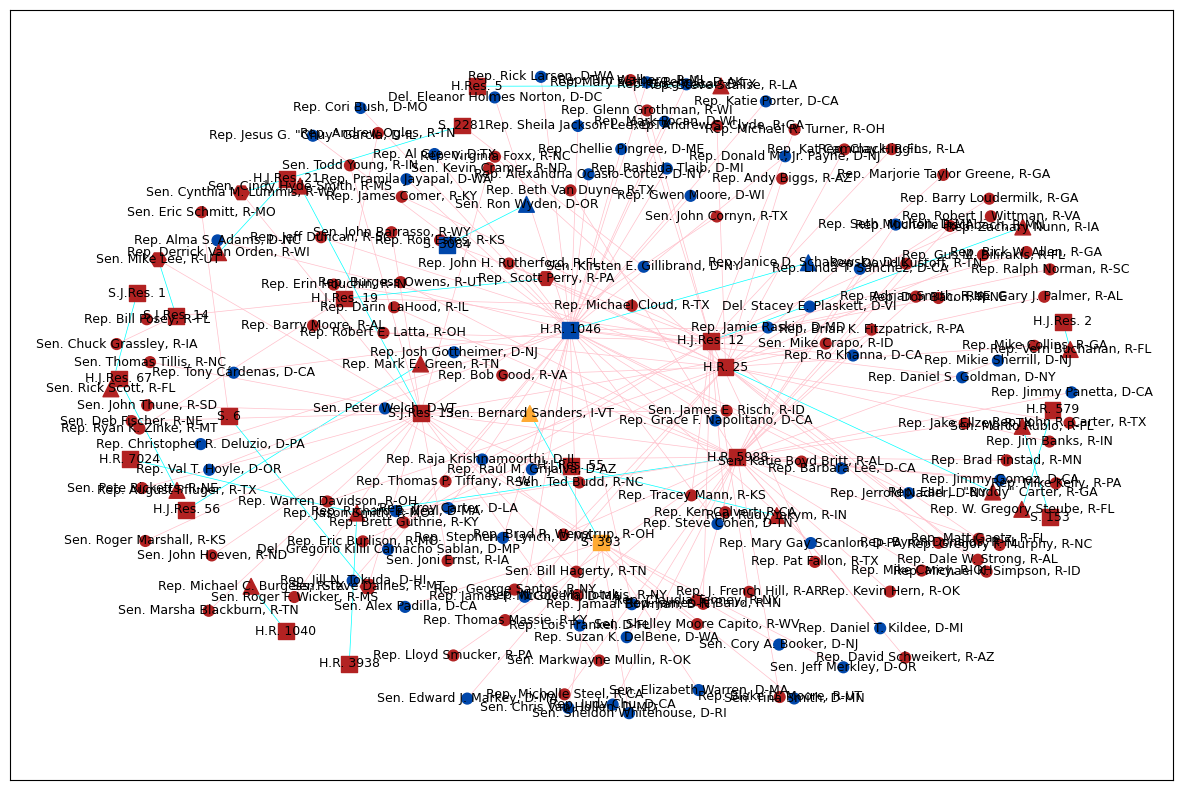

In [22]:
# chart networkx graph, just to check basic structure (this graph will be ugly)
## Get node labels from the 'label' attribute
labels = nx.get_node_attributes(G, 'label')

## Define node sizes based on node type, providing a default size if 'size' is missing
node_sizes = [G.nodes[node].get('size', 50) for node in G.nodes()]

## Calculate the layout
pos = nx.spring_layout(G, k=.5)  # Adjust 'k' for spacing

## Define node colors from node color attribute
node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'gray' for node in G.nodes()]

## Define node shapes
node_shapes = nx.get_node_attributes(G, 'shape') # dictionary of node:shape

## Define edge colors
edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'gray' for edge in G.edges()]

## Draw the graph
plt.figure(figsize=(15,10))

### Separate nodes by shape
o_nodes = [node for node, shape in node_shapes.items() if shape == 'o']
s_nodes = [node for node, shape in node_shapes.items() if shape == 's']
t_nodes = [node for node, shape in node_shapes.items() if shape == '^']
h_nodes = [node for node, shape in node_shapes.items() if shape == 'H']

## Draw each shape type separately
nx.draw_networkx_nodes(G, pos, nodelist=o_nodes, node_color=[node_colors[node] for node in o_nodes] if isinstance(node_colors, dict) else [node_colors[i] for i, node in enumerate(G.nodes) if node in o_nodes], node_size=[node_sizes[node] for node in o_nodes] if isinstance(node_sizes, dict) else [node_sizes[i] for i, node in enumerate(G.nodes) if node in o_nodes], node_shape='o')
nx.draw_networkx_nodes(G, pos, nodelist=s_nodes, node_color=[node_colors[node] for node in s_nodes] if isinstance(node_colors, dict) else [node_colors[i] for i, node in enumerate(G.nodes) if node in s_nodes], node_size=[node_sizes[node] for node in s_nodes] if isinstance(node_sizes, dict) else [node_sizes[i] for i, node in enumerate(G.nodes) if node in s_nodes], node_shape='s')
nx.draw_networkx_nodes(G, pos, nodelist=t_nodes, node_color=[node_colors[node] for node in t_nodes] if isinstance(node_colors, dict) else [node_colors[i] for i, node in enumerate(G.nodes) if node in t_nodes], node_size=[node_sizes[node] for node in t_nodes] if isinstance(node_sizes, dict) else [node_sizes[i] for i, node in enumerate(G.nodes) if node in t_nodes], node_shape='^')
nx.draw_networkx_nodes(G, pos, nodelist=h_nodes, node_color=[node_colors[node] for node in h_nodes] if isinstance(node_colors, dict) else [node_colors[i] for i, node in enumerate(G.nodes) if node in h_nodes], node_size=[node_sizes[node] for node in h_nodes] if isinstance(node_sizes, dict) else [node_sizes[i] for i, node in enumerate(G.nodes) if node in h_nodes], node_shape='H')

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=0.5) # Draw edges separately
nx.draw_networkx_labels(G, pos, labels, font_size=9) # Draw labels separately

plt.show()

In [23]:
# export edges to csv
G_edges = nx.to_pandas_edgelist(G)
edge_csv_path = os.path.join(out_dir, 'G_edges.csv')
G_edges.to_csv(edge_csv_path, index=False)

In [ ]:
# export nodes to csv
G_nodes = pd.DataFrame(list(G.nodes(data=True)), columns=['node', 'attributes'])
for i, row in G_nodes.iterrows():
    for key, value in row['attributes'].items():
        G_nodes.at[i, key] = value
G_nodes.drop(columns=['attributes'], inplace=True)
node_csv_path = os.path.join(out_dir, 'G_nodes.csv')
G_nodes.to_csv(node_csv_path, index=False)

In [ ]:
# retrieve nodes and edges from csv
# so you don't have to run all the previous code again to create a readable Plotly network diagram
node_path = os.path.join(out_dir, 'G_nodes.csv')
edge_path = os.path.join(out_dir, 'G_edges.csv')

# Create a new graph
Gfinal = nx.Graph()

# Open the nodes CSV file
with open(node_path, 'r') as f:
    reader = csv.reader(f)
    next(reader) # Skip the header row if it exists

    # Add nodes to the graph
    for row in reader:
        node_id = row[0] # Assuming the first column in the CSV is the node ID
        Gfinal.add_node(node_id)
        nx.set_node_attributes(Gfinal, {node_id: {'label': row[1], 'sponsor': row[2], 'type': row[3], 'size': row[4], 'color': row[5], 'shape': row[6], 'sponsored': row[7], 'cosponsored': row[8]}})

# Print the nodes in the graph
print(Gfinal.nodes(data=True))

# Open the eges CSV file
with open(edge_path, 'r') as f:
    reader = csv.reader(f)
    next(reader) # Skip the header row if it exists

    for row in reader:
      Gfinal.add_edge(row[0], row[1], color=row[2])

# Print the nodes in the graph
print(Gfinal.edges(data=True))

In [ ]:
# Plotly code adapted from 'https://plotly.com/python/network-graphs/'
# Calculate node positions using spring_layout
pos = nx.spring_layout(Gfinal, k=0.15, iterations=20)

# Add node positions to the graph
nx.set_node_attributes(Gfinal, pos, 'pos')

#Add edges as disconnected lines in a single trace and nodes as a scatter trace
edge_x = []
edge_y = []
for edge in Gfinal.edges():
    x0, y0 = Gfinal.nodes[edge[0]]['pos']
    x1, y1 = Gfinal.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    name="Edges",
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    showlegend=False,
    mode='lines')

node_x = []
node_y = []
for node in Gfinal.nodes():
    x, y = Gfinal.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

hover_text = [] #Create empty list to store hover text
included_attributes = ["label", "sponsor", "sponsored", "cosponsored"]  # List of attributes to include

for node in Gfinal.nodes():
    attributes = Gfinal.nodes[node]
    text = f""
    for attr_name, attr_value in attributes.items():
        if attr_name in included_attributes:
          if attr_value != "NA":
            text += f"{attr_name}: {attr_value}<br>"
    hover_text.append(text)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    name='Nodes',
    mode='markers',
    hoverinfo='text',
    text=hover_text,
    showlegend=False,
    marker=dict(
        color=[str(c) for c in nx.get_node_attributes(Gfinal, 'color').values()],
        size=[float(s)/4 for s in nx.get_node_attributes(Gfinal, 'size').values()],
        symbol=['square' if s == 's' else ('circle' if s == 'o' else 'triangle-down' if s == '^' else 'hexagon') for s in nx.get_node_attributes(Gfinal, 'shape').values()],
        line=dict(width=1, color='black'),
        showscale=False),
)

In [ ]:
# Plotly code adapted from 'https://plotly.com/python/network-graphs/'
# create initial Plotly diagram
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=dict(
                    text="<br><b>Network of Income Tax Rate Bills, Sponsors and Cosponsors, 118th Congress</b>",
                    font=dict(
                        size=16
                    )
                ),
                hovermode='closest',
                margin=dict(b=20,l=10,r=0,t=55),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.update_layout(width=1000, height=800, plot_bgcolor='#F1F1F1')

In [ ]:
# get a list of unique node colors for legend
unique_colors = set(nx.get_node_attributes(Gfinal, 'color').values())

# map the colors to the parties
color_map = {'#0047AB': 'Democrat', '#FFAA33': 'Independent', '#B22222': 'Republican'}

# Create separate traces for each legend item
for color in unique_colors:
    color_legend_trace = go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            color=color,
            size=15,
            symbol='circle'  # Use circle for all legend items
        ),
        name=color_map.get(color, "Unknown"),  # Single party name
        showlegend=True
    )
    fig.add_trace(color_legend_trace)  # Add each legend trace separately

fig.update_layout(
    legend=dict(
        x=1.05,
        y=1.0,
        title="Node Legend",
        traceorder="normal",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        orientation="v",
        itemclick=False,
        font=dict(size=10)
    )
)

In [ ]:
# get a list of unique node shapes for shape legend
unique_shapes = set(nx.get_node_attributes(Gfinal, 'shape').values())

# map the shapes to the node types
shape_map = {'s': 'Bill', 'o': 'Cosponsor', '^': 'Sponsor', 'H': 'Sponsor/Cosponsor'}

# map the shapes to the plotly symbol values
plotly_shape_map = {'s': 'square', 'o': 'circle', '^': 'triangle-down', 'H': 'hexagon'}

# Create separate traces for each legend item
for shape in unique_shapes:
    # Get the Plotly symbol value, defaulting to 'circle' if not found in the map
    plotly_symbol = plotly_shape_map.get(shape, 'circle')

    shape_legend_trace = go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            color='white',  # Use black for all legend items
            size=15,
            symbol=plotly_symbol, # Use the mapped or default symbol
            line=dict(width=1, color='black')
        ),
        name=shape_map.get(shape, "Unknown"),
        showlegend=True
    )
    fig.add_trace(shape_legend_trace)  # Add each legend trace separately

fig.update_layout(
    legend=dict(
        x=1.05,
        y=.75,
        title="Node Legend",
        traceorder="normal",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        orientation="v",
        itemclick=False,
        font=dict(size=10)
    )
)

In [ ]:
# set path for html output
html_path = os.path.join(out_dir, 'network.html')
# write interactive plot to html
fig.write_html(html_path)